<a href="https://colab.research.google.com/github/plingyy/22fall_hw/blob/main/5460_hw1_problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem3

(a)

In [ ]:
import torchvision as thv
train = thv.datasets.MNIST('./', download=True , train=True)
val = thv.datasets.MNIST('./', download=True , train=False)
print(train.data.shape , len(train.targets))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([60000, 28, 28]) 60000


In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
x_train = np.zeros([30000,28,28])
y_train = np.zeros([30000])
x_val = np.zeros([5000,28,28])
y_val = np.zeros([5000])

for i in range(10):
  x_train[i*3000:(i+1)*3000,:] = train.data[np.where(train.targets==i)][:3000,:,:].numpy()
  y_train[i*3000:(i+1)*3000] = np.array([i]*3000)
  x_val[i*500:(i+1)*500,:] = val.data[np.where(val.targets==i)][:500,:,:].numpy()
  y_val[i*500:(i+1)*500] = np.array([i]*500)

x_train = x_train.reshape(x_train.shape[0],-1)/255
x_val = x_val.reshape(x_val.shape[0],-1)/255

# shuffle data
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train, y_train = x_train[index], y_train[index]

index = np.arange(x_val.shape[0])
x_val, y_val = x_val[index], y_val[index]

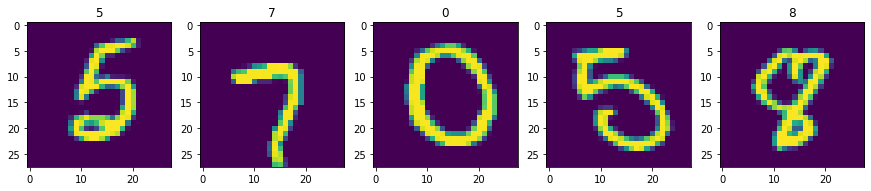

In [ ]:
fig = plt.figure(figsize=(15,3))
for t, i in enumerate(random.sample(range(30000),5)):
  fig.add_subplot(1,5,t+1)
  plt.title(np.array(int(y_train[i])))
  plt.imshow(x_train[i].reshape((28,28)))

(b)

In [ ]:
class linear_t:
  def __init__(self):
  # initialize to appropriate sizes , fill with Gaussian entires
  # normalize to make the Frobenius norm of w, b equal to 1
    self.w, self.b = np.random.rand(10,784), np.random.rand(10,1)
    self.w, self.b = self.w/np.linalg.norm(self.w, 'fro'), self.b/np.linalg.norm(self.b, 'fro')
    self.dw, self.db = 0, 0

  def forward(self, hl):
  # cache h^l in forward because we will need it to compute dw in backward
    self.hl = hl
    return np.matmul(hl, self.w.T) + self.b.T

  def backward(self, dhl):
    # notice that there is no need to cache dh^l
    self.dw = np.matmul(dhl.T,self.hl)
    self.db = np.matmul(dhl.T,np.ones([self.hl.shape[0], 1]))

  def zero_grad (self):
  # useful to delete the stored backprop gradients of the previous mini -batch before you start a new mini -batch
    self.dw , self.db = 0*self.dw , 0*self.db

  def check_backward(self, dhl1):
    i = random.choice(range(10))
    j = random.choice(range(784))
    
    epsilon = np.zeros_like(self.w)
    ij_epsilon = np.random.normal(0,1)
    epsilon[i,j] = ij_epsilon
    self.dw = (np.matmul(self.hl,(self.w+epsilon).T) - np.matmul(self.hl,(self.w-epsilon).T))/2*ij_epsilon

#### (c)

In [ ]:
class relu_t:
  def __init__(self):
    self.relu = 0

  def forward(self, hl):
    self.relu = np.maximum(0, hl)
    return self.relu

  def backward(self, dhl):
    return dhl * (self.relu > 0)

  def zero_grad (self):
  # useful to delete the stored backprop gradients of the previous mini -batch before you start a new mini -batch
    self.relu = 0*self.relu

#### (d)

In [ ]:
class softmax_cross_entropy_t:
  def __init__(self):
    # no parameters , nothing to initialize
    self.probability = []
    self.y = []

  def forward(self, hl, y):
    n = hl.shape[0]
    hl_exp = np.exp(hl)
    # prob = np.clip(hl_exp/np.sum(hl_exp,axis=1,keepdims=True),1e-8,1-(1e-8))
    prob = hl_exp/np.sum(hl_exp,axis=1,keepdims=True)
    self.probability = prob
    self.y = y
    # compute average loss ell(y) over a mini-batch
    ell = np.mean(-np.log(prob[range(n), y.astype(int)])) #for visualization/probability log sum of the right target
    error = np.sum(y != np.argmax(prob, axis=1)) / n #percentage that prediction is not target
    return ell, error

  def backward(self):
    n = self.probability.shape[0]
    self.probability[range(n), self.y.astype(int)] -= 1
    return self.probability/n

  def zero_grad (self):
  # useful to delete the stored backprop gradients of the previous mini -batch before you start a new mini -batch
    self.probability , self.y = 0*self.probability , 0*self.y

(e) check

In [ ]:
dhl1 = np.arange(10)
dhl1[5] = 1

(f) train

In [ ]:
# load dataset
lr = 0.01
batch_size = 32

# initialize all the layers
l1 , l2 , l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1 , l2 , l3]
train_loss = []
train_error = []


# train for at least 1000 iterations
for t in range(10):
  print('Epoch: ',t)
  index = np.arange(x_train.shape[0])
  np.random.shuffle(index)
  x_train, y_train = x_train[index], y_train[index]
  for j in range(int(len(x_train)/batch_size)):
  # 1. sample a mini -batch of size = 32 
  # each image in the mini -batch is chosen uniformly randomly from the training dataset
    x, y = x_train[j*batch_size:(j+1)*batch_size,:], y_train[j*batch_size:(j+1)*batch_size]

  # 2. zero gradient buffer
    for l in net:
      l.zero_grad ()

    # 3. forward pass
    h1 = l1.forward(x)
    h2 = l2.forward(h1)
    ell , error = l3.forward(h2 , y)

    # 4. backward pass
    dh2 = l3.backward ()
    dh1 = l2.backward(dh2)
    dx = l1.backward (dh1)

    # 5. gather backprop gradients
    dw, db = l1.dw, l1.db

    # 6. print some quantities for logging
    # and debugging
    print(t, ell , error)
    # print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))
    train_error.append(error)
    train_loss.append(ell)
    # 7. one step of SGD

    l1.w = l1.w - lr*dw
    l1.b = l1.b - lr*db

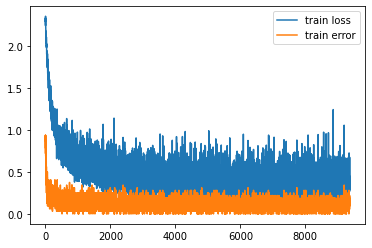

In [ ]:
plt.plot(range(len(train_loss)),train_loss,label='train loss')
plt.plot(range(len(train_error)),train_error,label='train error')
plt.legend()

(g) validation

In [ ]:
def validate(w, b):
# 1. iterate over mini-batches from the validation dataset
# note that this should not be done randomly , we want to check
# every image only once 
  loss, tot_error = [], []
  for i in range(0, 5000, 32):
    x, y = x_val[i:i+32], y_val[i:i+32]

# 2. compute forward pass and error
    hl = np.maximum(0, np.matmul(x, w.T) + b.T)
    n = hl.shape[0]
    hl_exp = np.exp(hl)
    prob = hl_exp/np.sum(hl_exp,axis=1,keepdims=True)
    # compute average loss ell(y) over a mini-batch
    ell = np.mean(-np.log(prob[range(n), y.astype(int)])) #for visualization/probability log sum of the right target
    error = np.sum(y != np.argmax(prob, axis=1)) / n

    loss.append(ell)
    error.append(error)

  return loss, error

In [ ]:
loss, error = validate(l1.w, l1.b)

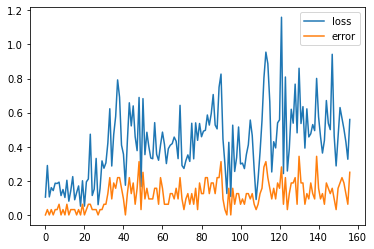

In [ ]:
plt.plot(range(len(loss)),loss,label='loss')
plt.plot(range(len(error)),error,label='error')
plt.legend()

(h) Pytorch

In [ ]:
import torch
from torch import nn

class MyLinear(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_features, out_features))
    self.bias = nn.Parameter(torch.randn(out_features))

  def forward(self, input):
    return (input @ self.weight) + self.bias

import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.l0 = MyLinear(784, 10)
    
  def forward(self, x):
    x = self.l0(x)
    x = F.relu(x)
    
    return x

In [ ]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [ ]:
# Move all parameters to a CUDA device
net.to(device='cuda')
# net.to('cpu')

# Change precision of all parameter
net.to(dtype=torch.float64)

In [ ]:
batch_size = 128
train_loss = []
train_err = []
val_loss = []
val_err = []

for j in range(50):
  print('Epoch: ',j)
  index = np.arange(x_train.shape[0])
  np.random.shuffle(index)
  x_train, y_train = x_train[index], y_train[index]
  for i in range(int(len(x_train)/batch_size)):
    x = x_train[i*batch_size:(i+1)*batch_size]
    y = y_train[i*batch_size:(i+1)*batch_size]
    optimizer.zero_grad()
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    relu_output = net(x)
    loss = nn.CrossEntropyLoss()(relu_output, y.long())
    
    prob, index = torch.max(relu_output,1)
    train_loss.append(loss.item())
    train_err.append(np.mean(np.array(y)!= (index.numpy())))

    loss.backward()
    optimizer.step()

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49


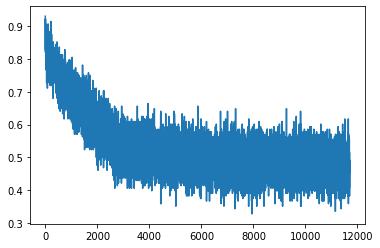

In [ ]:
plt.plot(range(len(train_err)),train_err)

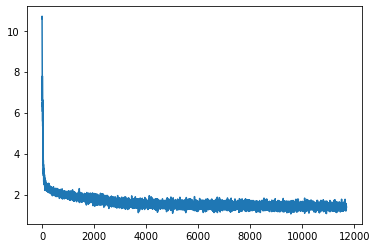

In [ ]:
plt.plot(range(len(train_loss)),train_loss)